# 2. Using Backbone Models and Fine Tuning 

### 2.2 Transfer Learning Using Autoencoder Latent Features (Block 2 Classification)

In [1]:
# This notebook will cover:
# - Transfer learning from the autoencoder to classify Block 2 images

In [1]:
# (a) Import necessary libraries
# --------------------------------------------------------------------

import numpy as np
import tensorflow as tf                                     # it contains already all the Keras modules

from sklearn.model_selection import train_test_split                    # for splitting the block 2 dataset into training and validation sets
from sklearn.metrics import confusion_matrix, classification_report     # for evaluation metrics and confusion matrix visualization

import json                                                             # for saving training history as JSON

from matplotlib import pyplot as plt                                    # for plotting confusion matrix
import seaborn as sns                                                  # for confusion matrix heatmap                  

In [2]:
# (b) Load the saved datasets and latent features and labels
# --------------------------------------------------------------------

# Load Block 1 datasets that were created to train the autoencoder and will be used 
#X_block1_input = np.load('X_block1_input.npy')          # shapes: (num_samples for Block 1, 64, 64, 3) for images
#y_block1_target = np.load('y_block1_target.npy')        # shape: (num_samples for Block 1, ) for labels
# print(X_block1_input.shape, y_block1_target.shape)      # 5282 samples in Block 1, 60% of total 6603 samples excluding test set of 974 samples
# ----->  not needed for later transfer learning part or fine-tuning part                                                        

# Load Block 2 datasets that will be used for transfer learning and classification
#X_block2_input = np.load('X_block2_input.npy')          # shapes: (num_samples for Block 2, 64, 64, 3) for images
#  ----> it will not be used as the X_block2_latent was created from it by passing it through the trained encoder (frozen_encoder)

y_block2_target = np.load('y_block2_target.npy')        # shape: (num_samples for Block 2, ) for labels
print(y_block2_target.shape)      # 3522 samples in Block 2, 40% of total 6603 samples excluding test set of 974 samples

# Load latent features
    # these were created by passing Block 2 images through the trained encoder from previous notebook and will be used as input features for classification
    # shapes: (num_samples, latent_dim); the num_smaples 
    # e.g. X_train_latent has shape (6000, 128) meaning 6000 samples each represented by 128-dim latent feature vector

# Load latent features for Block 2 dataset that will be used for transfer learning and Test dataset for final evaluation
    # they were created in previous notebook by passing Block 2 images through the trained encoder (frozen_encoder to avoid further training and changes to weights of encoder)
X_block2_latent = np.load("X_block2_latent.npy")                # shapes: (3522 samples, latent_dim=128) 

X_test_latent  = np.load("X_test_latent.npy")                   # shapes: (974 samples, latent_dim=128)
y_test_cls = np.load("y_test_cls_ohe.npy")                      # shape: (974 samples, num_classes)

print("Latent feature shapes:", X_block2_latent.shape)
print("Label shapes:", y_block2_target.shape)
print("Test label shape:", y_test_cls.shape)

# -----> For training the classifier (transfer learning) on Block 2 latent features and labels:
#           Input features: X_block2_latent
#           Target labels: y_block2_target
#       For evaluating the final model on Test set:
#           Input features: X_test_latent
#           Target labels: y_test_cls 
# --------------------------------------------------------------------        


(3522, 6)
Latent feature shapes: (3522, 128)
Label shapes: (3522, 6)
Test label shape: (974, 6)


In [ ]:
# (c) Split Block 2 dataset into training and validation sets
# --------------------------------------------------------------------

# tranfrom y_block2_target to 1D array of class labels (integer) as it is in one-hot encoded format (num_samples, num_classes) instead of (num_samples, )
    # argmax returns the indices of the maximum values along an axis; here axis=1 means along the columns (classes)
y_block2_int = np.argmax(y_block2_target, axis=1)        # 5 labels (0 to 4) for 5 age categories, shape: (num_samples for Block 2, )
print("Block 2 integer labels shape:", y_block2_int.shape)

# Using sklearn's train_test_split to create training and validation sets from Block 2 latent features and labels;
# random_state (42 is a commonly used arbitrary choice) for reproducibility (so that the same split is obtained each time the code is run);
# test_size=0.2 means 20% of Block 2 data will be used for validation;  
# shuffle to ensure random distribution of samples;
# stratified splitting to maintain class distribution in both sets (training and validation); 
    # this is important for classification tasks to ensure both sets represent all classes proportionally.

X_train_lat, X_val_lat, y_train_cls, y_val_cls = train_test_split(
    X_block2_latent, 
    y_block2_target,                    # still keep one-hot for the model training as categorical_crossentropy loss expects one-hot labels
    test_size=0.2,
    random_state=42, 
    shuffle=True,
    stratify=y_block2_int               # stratified splitting based on 5 class labels
)

Block 2 integer labels shape: (3522,)


In [ ]:
# (c) Build the classification model using the encoder's latent features as input
# --------------------------------------------------------------------


def build_classifier(input_shape=(128,), num_classes=y_block2_target.shape[1]):     # number of classes from one-hot encoded labels shape
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),         # input shape is latent feature vector shape
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),                     # 0.3 dropout chosen to reduce overfitting (lower enough to retain important features, high enough to prevent overfitting) 
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation='softmax')   # output layer with softmax for multi-class classification
    ])
    return model
# --------------------------------------------------------------------

In [6]:
# (d) Compile and train the classifier; save the training history and the trained model
# --------------------------------------------------------------------

# The hyperparameters such as number of epochs, batch size, learning rate, and architecture can be tuned further for better performance.

# Compile the model
classifier_model = build_classifier()
classifier_model.compile(
    optimizer='adam',                                       # Adam optimizer for training as it adapts learning rate
    loss='categorical_crossentropy',                        # categorical crossentropy loss for multi-class classification with one-hot labels
    metrics=['accuracy']                                    # track accuracy during training
)

# Train the model
history = classifier_model.fit(
    X_train_lat, 
    y_train_cls,
    validation_data=(X_val_lat, y_val_cls),
    epochs=30,                                              # enough iterations for convergence as the dataset is relatively small
    batch_size=32                                           # a standard size for this type of model, a good trade-off between stability and speed
)

# Save the history as a JSON file for later plotting
with open('classifier_training_history.json', 'w') as f:
    json.dump(history.history, f)

print("Saved training history as JSON: classifier_training_history.json")

# Save the trained classifier model
classifier_model.save('classifier_model_block2.keras')            # directory format, SavedModel format, to avoid "Insufficient precision" error in .keras format
print("Saved model: classifier_model_block2")
# --------------------------------------------------------------------

Epoch 1/30
89/89 [==============================] - 32s 51ms/step - loss: 1.7408 - accuracy: 0.3571 - val_loss: 1.3337 - val_accuracy: 0.4865
Epoch 2/30
89/89 [==============================] - 1s 6ms/step - loss: 1.3301 - accuracy: 0.4732 - val_loss: 1.1823 - val_accuracy: 0.5362
Epoch 3/30
89/89 [==============================] - 0s 5ms/step - loss: 1.1582 - accuracy: 0.5438 - val_loss: 1.1128 - val_accuracy: 0.5574
Epoch 4/30
89/89 [==============================] - 0s 4ms/step - loss: 1.0780 - accuracy: 0.5744 - val_loss: 1.0689 - val_accuracy: 0.5816
Epoch 5/30
89/89 [==============================] - 0s 4ms/step - loss: 1.0171 - accuracy: 0.5960 - val_loss: 1.0434 - val_accuracy: 0.5887
Epoch 6/30
89/89 [==============================] - 0s 4ms/step - loss: 0.9663 - accuracy: 0.6042 - val_loss: 1.0453 - val_accuracy: 0.5801
Epoch 7/30
89/89 [==============================] - 0s 4ms/step - loss: 0.9271 - accuracy: 0.6305 - val_loss: 1.0425 - val_accuracy: 0.5830
Epoch 8/30
89/89 [

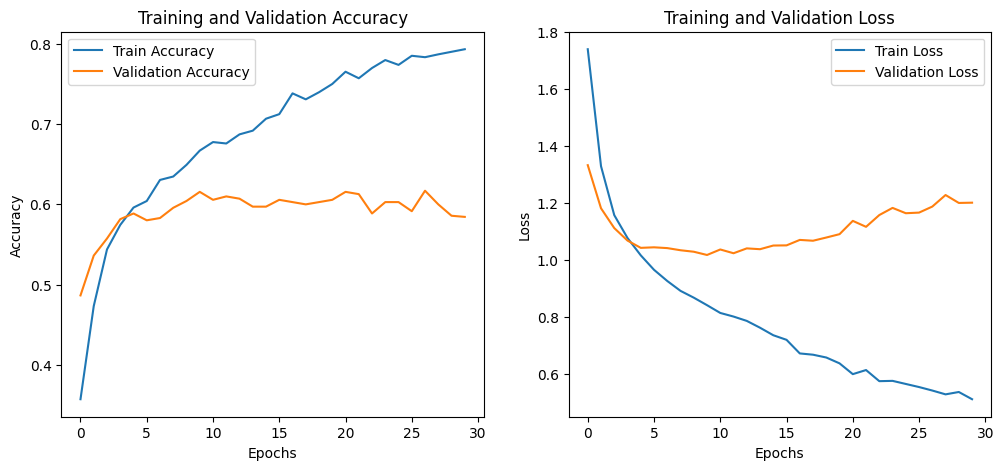

In [7]:
# (e) Plot training history
# --------------------------------------------------------------------

# Load the history from JSON
with open('classifier_training_history.json', 'r') as f:
    history_data = json.load(f)

# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 5))

# Plot accuracy curves
plt.subplot(1, 2, 1)                                                    # accuracy plot with 1 row, 2 columns, first subplot 
plt.plot(history_data['accuracy'], label='Train Accuracy')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss curves
plt.subplot(1, 2, 2)
plt.plot(history_data['loss'], label='Train Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [8]:
# (e) Evaluate the classifier on the Test set
# --------------------------------------------------------------------

# to obtain final performance metrics on completely unseen data
test_loss, test_accuracy = classifier_model.evaluate(X_test_latent, y_test_cls)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# --------------------------------------------------------------------

31/31 [==============================] - 0s 5ms/step - loss: 1.0638 - accuracy: 0.6458
Test Loss: 1.0638, Test Accuracy: 0.6458


In [9]:
# (f) Get predictions for confusion matrix and metrics
# --------------------------------------------------------------------

y_test_pred = classifier_model.predict(X_test_latent)          # predicted probabilities for each class

# Convert one-hot into integer class index to compare with predicted class indices 
y_test_true_int = np.argmax(y_test_cls, axis=1)
y_test_pred_int = np.argmax(y_test_pred, axis=1)

31/31 [==============================] - 0s 2ms/step


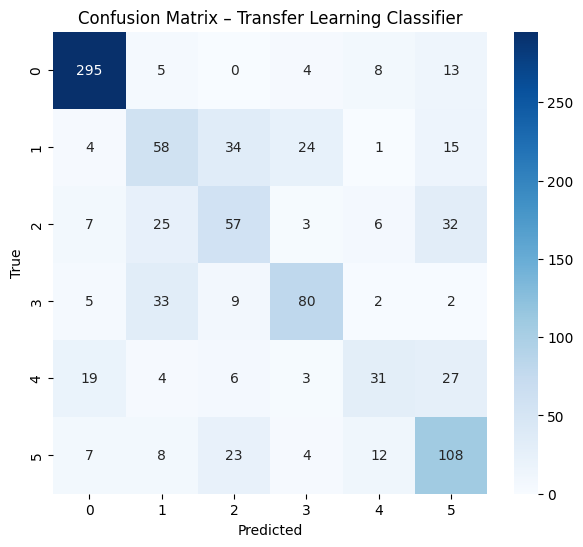

              precision    recall  f1-score   support

           0       0.88      0.91      0.89       325
           1       0.44      0.43      0.43       136
           2       0.44      0.44      0.44       130
           3       0.68      0.61      0.64       131
           4       0.52      0.34      0.41        90
           5       0.55      0.67      0.60       162

    accuracy                           0.65       974
   macro avg       0.58      0.57      0.57       974
weighted avg       0.64      0.65      0.64       974



In [10]:
# (g) Confusion matrix and classification report
# --------------------------------------------------------------------

# Plot a confusion matrix
    # cm shows how many samples were correctly or incorrectly classified:
    # rows = true classes, columns = predicted classes
    # each cell contains the count of (true_label, predicted_label) pairs;
        # it shows directly the true_positives along the diagonal 
        # false_negatives for each row (off the diagonal in that row)
        # false_positives for each column (off the diagonal in that column)
        # true_negatives can be inferred from the other values (not directly shown in cm, it would be total samples - (TP + FP + FN) for each class)
cm = confusion_matrix(y_test_true_int, y_test_pred_int)

plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – Transfer Learning Classifier")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification report
    # precision: proportion of predicted positives that are actually correct  =  TP / (TP + FP)
    # recall: proportion of actual positives that are correctly identified  =  TP / (TP + FN)
    # f1-score: harmonic mean of precision and recall, providing a balanced measure when classes are imbalanced
    # accuracy: overall proportion of correct predictions  =  (TP + TN) / total samples
    # macro avg: unweighted mean of metrics for all classes, treating all classes equally
    # weighted avg: mean of metrics for all classes, weighted by number of samples in each class
print(classification_report(y_test_true_int, y_test_pred_int))

In [ ]:
# (h) Classification Results Summary (Transfer Learning on Latent Features)
# --------------------------------------------------------------------
# Overall test accuracy: ~65%.

# Precision/recall/F1 vary across age categories:
#   - Class 0 = Child (0–12): strong performance (highest precision/recall)
#   - Class 1 = Teen (13–19): moderate performance
#   - Class 2 = Youth (20–30): moderate performance
#   - Class 3 = Mid-age (31–45): fairly stable performance
#   - Class 4 = Mature (46–60): weaker performance
#   - Class 5 = Older (61+): moderate performance

# Larger classes (especially Child) are predicted more accurately, while smaller classes (e.g., Mature) show lower precision/recall.
# Macro F1 (~0.57) indicates moderate performance averaged across all classes.
# Weighted F1 (~0.64) reflects the influence of dominant classes.
# Overall, the autoencoder’s latent features helped the classifier, but class imbalance and overlapping visual features remain limiting factors.
# Further gains are possible via additional data augmentation, class balancing (e.g., weighting or oversampling), or deeper tuning.